C:\Users\muham\AppData\Local\Temp\ipykernel_23868\1315554351.py:10: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


Total events in CSV file: 200000
Total events selected: 268


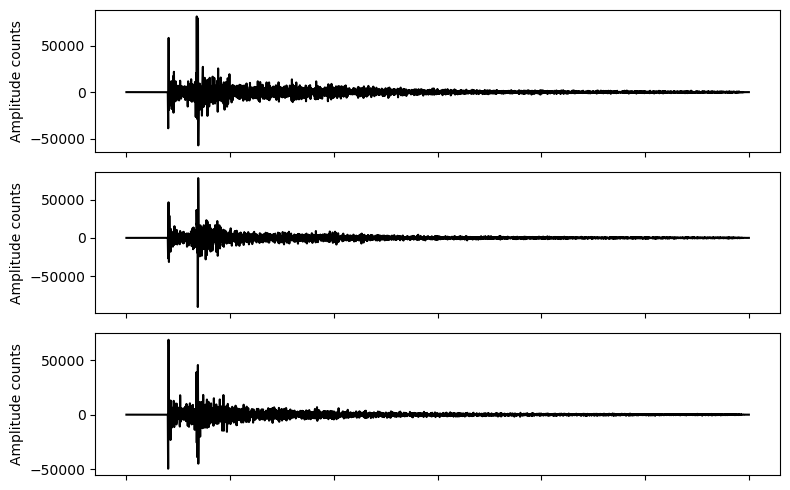

In [1]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt

file_name = "data/chunk2.hdf5"  # use your file name
csv_file = "data/chunk2.csv"

# reading the csv file into a dataframe:
df = pd.read_csv(csv_file)
print(f'Total events in CSV file: {len(df)}')

# filtering the dataframe
df = df[(df.trace_category == 'earthquake_local') & (df.source_distance_km <= 20) & (df.source_magnitude > 3)]
print(f'Total events selected: {len(df)}')

# making a list of trace names for the selected data
ev_list = df['trace_name'].to_list()

# retrieving selected waveforms from the hdf5 file:
dtfl = h5py.File(file_name, 'r')

# Only plot one waveform (the first one)
evi = ev_list[0]  # take the first event
dataset = dtfl.get('data/' + str(evi))
data = np.array(dataset)  # waveforms: columns 0 = E, 1 = N, 2 = Z

fig, axs = plt.subplots(3, 1, figsize=(8, 5))

for i in range(3):
    axs[i].plot(data[:, i], 'k')
    axs[i].set_ylabel('Amplitude counts', fontsize=10)
    axs[i].set_xticklabels([])

plt.tight_layout()
plt.show()


In [6]:
import pandas as pd
import h5py
import numpy as np
import os

# File paths
csv_file = "data/chunk2.csv"
hdf5_file = "data/chunk2.hdf5"

# Step 1: Load and filter metadata
df = pd.read_csv(csv_file)
df = df[(df.trace_category == 'earthquake_local') &
        (df.source_distance_km <= 20) &
        (df.source_magnitude > 3)]

# Make list of trace names
trace_list = df['trace_name'].tolist()

print(f"Selected {len(trace_list)} events.")

# Step 2: Open HDF5 and extract waveform data for each trace
h5_file = h5py.File(hdf5_file, 'r')

X_data = []   # waveform data
y_data = []   # target magnitudes

# Parameters
max_length = 6000  # truncate or pad waveform to 6000 timesteps

for trace_name in trace_list:
    try:
        dataset = np.array(h5_file['data/' + trace_name])  # (timesteps, 3)
        
        # Ensure waveform has sufficient length
        if dataset.shape[0] >= max_length:
            trimmed = dataset[:max_length, :]
        else:
            # Zero-pad if shorter
            pad_width = max_length - dataset.shape[0]
            trimmed = np.pad(dataset, ((0, pad_width), (0, 0)), mode='constant')

        X_data.append(trimmed)
        y_data.append(df[df.trace_name == trace_name]['source_magnitude'].values[0])
        
    except Exception as e:
        print(f"Skipping {trace_name}: {e}")

X_data = np.array(X_data)
y_data = np.array(y_data)

print(f"Shape of waveform data: {X_data.shape}")  # (num_samples, timesteps, 3)
print(f"Shape of labels: {y_data.shape}")


C:\Users\muham\AppData\Local\Temp\ipykernel_23868\2965639979.py:11: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


Selected 268 events.
Shape of waveform data: (268, 6000, 3)
Shape of labels: (268,)


In [7]:
# Normalize per trace
def normalize_waveform(trace):
    mean = np.mean(trace, axis=0)
    std = np.std(trace, axis=0)
    return (trace - mean) / std

X_normalized = np.array([normalize_waveform(trace) for trace in X_data])


In [8]:
from obspy import Stream, Trace
import os
import numpy as np

output_dir = "waveforms_mseed"
os.makedirs(output_dir, exist_ok=True)

def save_mseed(trace_data, trace_name, output_dir):
    sampling_rate = 100  # Hz
    channels = ['E', 'N', 'Z']
    st = Stream()

    # Split station and network from trace_name (e.g., A16.CN → A16, CN)
    station_id = trace_name.split('_')[0]
    station = station_id.split('.')[0]
    network = station_id.split('.')[1] if '.' in station_id else "XX"

    for i, comp in enumerate(channels):
        tr = Trace()
        tr.data = trace_data[:, i].astype(np.float32)
        tr.stats.station = station       # e.g., A16
        tr.stats.network = network       # e.g., CN
        tr.stats.channel = comp          # E, N, or Z
        tr.stats.sampling_rate = sampling_rate
        st.append(tr)

    st.write(os.path.join(output_dir, f"{trace_name}.mseed"), format="MSEED")
    
for trace_data, trace_name in zip(X_normalized, trace_list):
    try:
        save_mseed(trace_data, trace_name, output_dir)
    except Exception as e:
        print(f"Error saving {trace_name}: {e}")


In [9]:
import os
import pandas as pd

mseed_dir = 'waveforms_mseed'
mseed_files = sorted([f for f in os.listdir(mseed_dir) if f.endswith('.mseed')])

# Include the full filename
df = pd.DataFrame({'fname': mseed_files})
df.to_csv('mseed.csv', index=False)

print("✅ Fixed mseed.csv: now includes full filenames with .mseed")


✅ Fixed mseed.csv: now includes full filenames with .mseed


In [10]:
cd PhaseNet/

e:\files\EMP\PhaseNet


In [12]:
!python phasenet/predict.py \
  --model=model/190703-214543 \
  --data_list=mseed.csv \
  --data_dir=waveforms_mseed \
  --format=mseed \
  --amplitude \
  --batch_size=1 \
  --sampling_rate=100


Done with 313 P-picks and 313 S-picks


2025-05-06 12:22:12,567 Pred log: results
2025-05-06 12:22:12,567 Dataset size: 268
2025-05-06 12:22:12.610396: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-06 12:22:12,630 Model: depths 5, filters 8, filter size 7x1, pool size: 4x1, dilation rate: 1x1
2025-05-06 12:22:13.717000: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2025-05-06 12:22:13,878 restoring model model/190703-214543\model_95.ckpt

Pred: 100%|██████████| 268/268 [00:02<00:00, 108.75it/s]


In [13]:
import pandas as pd
import os

sample_file = [f for f in os.listdir("results") if f.endswith(".csv")][0]
df = pd.read_csv(os.path.join("results", sample_file))
print(df.columns)
print(df.head())


Index(['station_id', 'begin_time', 'phase_index', 'phase_time', 'phase_score',
       'phase_type', 'file_name', 'phase_amplitude', 'phase_amp'],
      dtype='object')
  station_id               begin_time  phase_index               phase_time  \
0   CN.A16..  1970-01-01T00:00:00.000          399  1970-01-01T00:00:03.990   
1   CN.A16..  1970-01-01T00:00:00.000          672  1970-01-01T00:00:06.720   
2   CN.A64..  1970-01-01T00:00:00.000          900  1970-01-01T00:00:09.000   
3   CN.A64..  1970-01-01T00:00:00.000         1120  1970-01-01T00:00:11.200   
4  C1.AC04..  1970-01-01T00:00:00.000          600  1970-01-01T00:00:06.000   

   phase_score phase_type                        file_name  phase_amplitude  \
0        0.980          P   A16.CN_20150121053158_EV.mseed        22.207033   
1        0.912          S   A16.CN_20150121053158_EV.mseed        22.207033   
2        0.603          P   A64.CN_20130711201601_EV.mseed        37.021805   
3        0.682          S   A64.CN_201307

In [14]:
import os

results_dir = "results"
csv_files = [f for f in os.listdir(results_dir) if f.endswith(".csv")]
print(f"🔍 Total CSVs from PhaseNet: {len(csv_files)}")
print("📂 Example files:", csv_files[:5])


🔍 Total CSVs from PhaseNet: 1
📂 Example files: ['picks.csv']


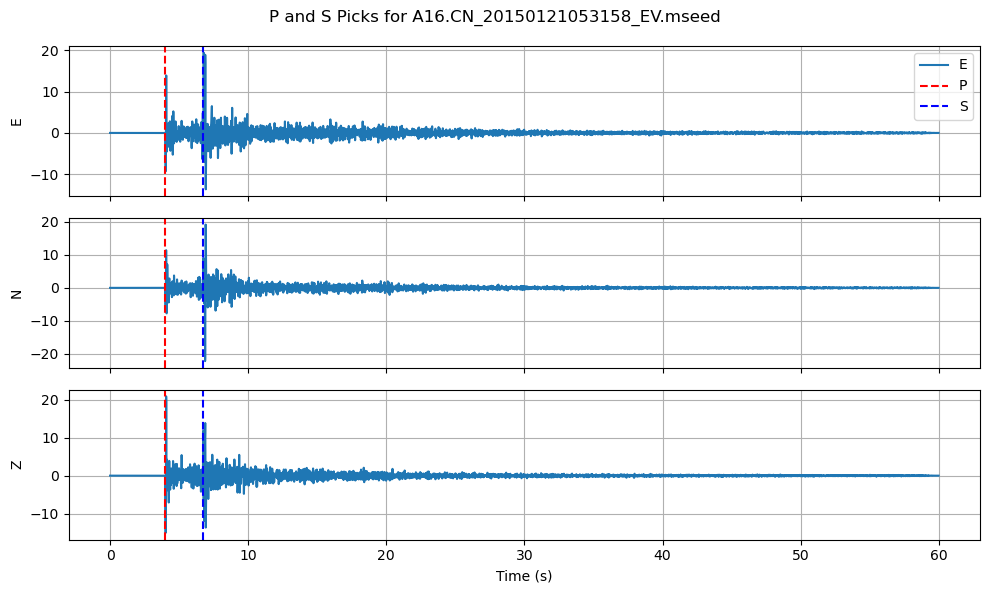

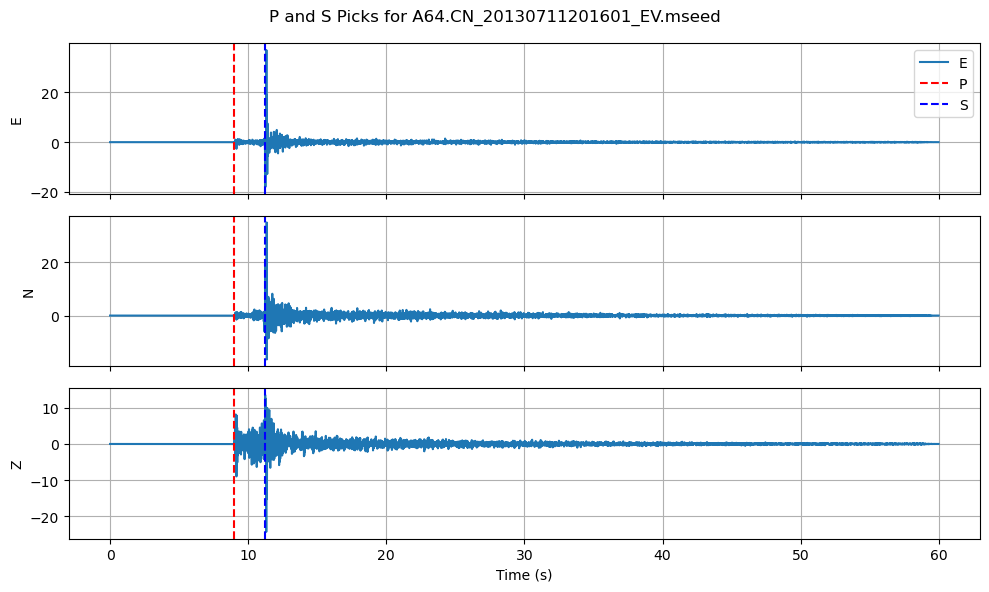

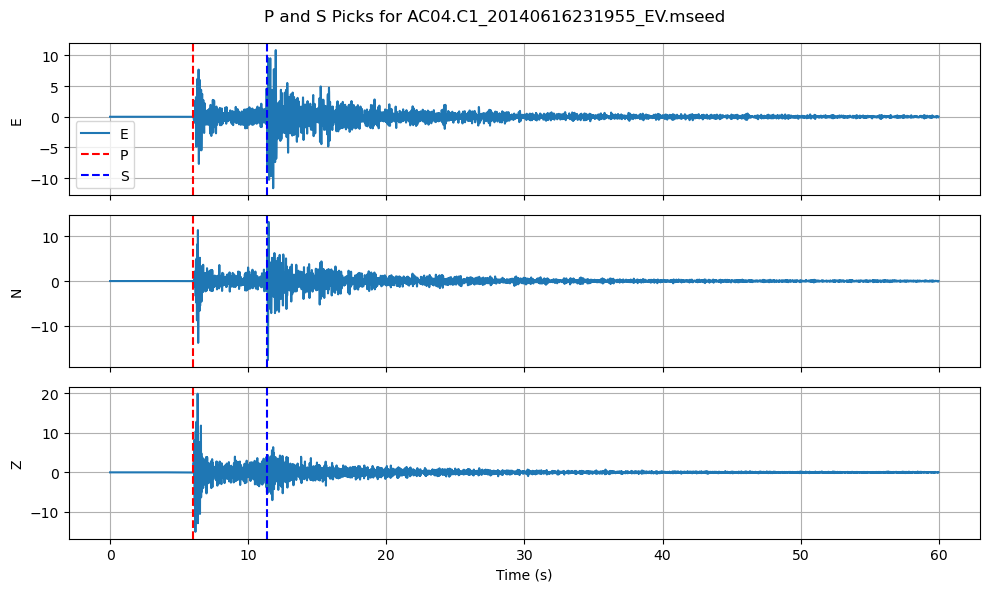

In [17]:
import obspy
import matplotlib.pyplot as plt
import os
import pandas as pd
picks_df = pd.read_csv("results/picks.csv")

# We'll pick a few unique filenames from the picks.csv file
unique_files = picks_df['file_name'].unique()[:3]  # Take the first 3 files for demonstration
waveform_dir = "waveforms_mseed"

def plot_waveform_with_picks(file_name, picks_df, waveform_dir):
    file_path = os.path.join(waveform_dir, file_name)
    try:
        stream = obspy.read(file_path)
        fig, axs = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
        channels = ['E', 'N', 'Z']

        # Plot the data
        for i, comp in enumerate(channels):
            trace = stream.select(channel=comp)[0]
            times = trace.times()
            axs[i].plot(times, trace.data, label=comp)
            axs[i].set_ylabel(comp)
            axs[i].grid(True)

            # Plot P and S picks if available
            picks = picks_df[(picks_df['file_name'] == file_name) & (picks_df['phase_type'].isin(['P', 'S']))]
            for _, row in picks.iterrows():
                axs[i].axvline(x=row['phase_index'] / 100.0, linestyle='--', color='r' if row['phase_type'] == 'P' else 'b', label=row['phase_type'])

        axs[0].legend()
        axs[-1].set_xlabel("Time (s)")
        fig.suptitle(f"P and S Picks for {file_name}")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Could not plot {file_name}: {e}")

# Plot for each selected file
for fname in unique_files:
    plot_waveform_with_picks(fname, picks_df, waveform_dir)



In [18]:
import numpy as np

# Save the waveform array
np.save("X_normalized.npy", X_normalized)

# Save the corresponding magnitude labels
np.save("y_data.npy", y_data)

# Save the list of waveform filenames
np.save("trace_list.npy", np.array(trace_list))


In [23]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ------------------ CONFIGURATION ------------------
PICK_CSV_PATH = 'results/picks.csv'              # Output from PhaseNet
TRACE_LIST = 'trace_list.npy'            # List of filenames used for each waveform
WAVEFORM_DATA = 'X_normalized.npy'       # Shape: (N, T, 3)
MAGNITUDE_LABELS = 'y_data.npy'          # Shape: (N,)
MSEED_SUFFIX = '.mseed'
ALIGNMENT_WINDOW = 3000                  # Length of trimmed window centered on P-pick
# ---------------------------------------------------


def load_data():
    print("📦 Loading data...")
    picks_df = pd.read_csv(PICK_CSV_PATH)
    trace_list = np.load(TRACE_LIST, allow_pickle=True)
    X_data = np.load(WAVEFORM_DATA)
    y_data = np.load(MAGNITUDE_LABELS)
    return X_data, y_data, trace_list, picks_df


def extract_p_picks(picks_df):
    print("🔍 Extracting P-pick indices...")
    p_picks = picks_df[picks_df['phase_type'] == 'P']
    return dict(zip(p_picks['file_name'], p_picks['phase_index']))


def align_waveform_to_p(waveform, p_index, window=3000):
    start = max(p_index - 500, 0)
    end = start + window
    if end > waveform.shape[0]:
        pad_width = end - waveform.shape[0]
        waveform = np.pad(waveform, ((0, pad_width), (0, 0)), mode='constant')
    return waveform[start:end]


def preprocess_data(X_data, y_data, trace_list, file_to_p_index, window=3000):
    print("🧹 Aligning and filtering waveforms...")
    X_aligned, y_aligned = [], []
    for trace, fname, mag in zip(X_data, trace_list, y_data):
        fname = fname if fname.endswith(MSEED_SUFFIX) else fname + MSEED_SUFFIX
        if fname in file_to_p_index:
            p_idx = file_to_p_index[fname]
            aligned = align_waveform_to_p(trace, p_idx, window)
            X_aligned.append(aligned)
            y_aligned.append(mag)
    return np.array(X_aligned), np.array(y_aligned)


def normalize_waveforms(X):
    print("⚖️  Normalizing waveforms...")
    N, T, C = X.shape
    X_flat = X.reshape(-1, C)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_flat).reshape(N, T, C)
    return X_scaled


def build_lstm_model(input_shape):
    print("🧠 Building LSTM model...")
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1)  # Magnitude output
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model


def main():
    X_data, y_data, trace_list, picks_df = load_data()
    file_to_p_index = extract_p_picks(picks_df)
    X_aligned, y_aligned = preprocess_data(X_data, y_data, trace_list, file_to_p_index, window=ALIGNMENT_WINDOW)
    X_scaled = normalize_waveforms(X_aligned)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_aligned, test_size=0.2, random_state=42)

    model = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    
    # Callbacks
    checkpoint_cb = ModelCheckpoint("best_magnitude_lstm_model.h5", 
                                    monitor='val_loss', 
                                    save_best_only=True, 
                                    verbose=1)
    
    earlystop_cb = EarlyStopping(monitor='val_loss', 
                                 patience=10, 
                                 restore_best_weights=True,
                                 verbose=1)

    print("🚀 Training model...")
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=16,
        validation_split=0.2,
        callbacks=[checkpoint_cb, earlystop_cb]
    )

    print("📈 Evaluating on test set...")
    mse, mae = model.evaluate(X_test, y_test)
    print(f"\n✅ Test MAE: {mae:.3f}, Test MSE: {mse:.3f}")

    # Optional: save the final model (even if not the best one)
    model.save("last_magnitude_lstm_model.h5")


if __name__ == "__main__":
    main()


📦 Loading data...
🔍 Extracting P-pick indices...
🧹 Aligning and filtering waveforms...
⚖️  Normalizing waveforms...
🧠 Building LSTM model...
🚀 Training model...
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 13.1867 - mae: 3.6038
Epoch 1: val_loss improved from inf to 12.04737, saving model to best_magnitude_lstm_model.h5
11/11 [==============================] - 16s 1s/step - loss: 13.1867 - mae: 3.6038 - val_loss: 12.0474 - val_mae: 3.4355
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 9.8547 - mae: 3.0811 
Epoch 2: val_loss improved from 12.04737 to 2.78016, saving model to best_magnitude_lstm_model.h5
11/11 [==============================] - 15s 1s/step - loss: 9.8547 - mae: 3.0811 - val_loss: 2.7802 - val_mae: 1.5916
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 1.1266 - mae: 0.8547
Epoch 3: val_loss improved from 2.78016 to 0.75673, saving model to best_magnitude_lstm_model.h5
11/11 [==============================] - 